In [1]:
import sys
import os
import glob
sys.path.append(os.path.abspath('../../Code/Software/CarDpy-master'))
from cardpy.Sample_Data.Data_Paths import *
from cardpy.Data_Import            import *
from cardpy.Data_Sorting           import *
from cardpy.Data_Processing.DTI    import *
from cardpy.GUI_Tools              import IntERCOMS
from cardpy.Colormaps              import *
from cardpy.Data_Saving            import *
from cardpy.Data_Processing.cDTI   import *
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import nrrd

from dipy.denoise.localpca import mppca
from   dipy.core.gradients             import gradient_table                                                                    # Import gradient table from DiPy
from   dipy.denoise.patch2self         import patch2self                                                                        # Import patch to self-denoising from DiPy
from   dipy.denoise.noise_estimate     import estimate_sigma                                                                    # Import non-local means denoising sigma estimate from DiPy
from   dipy.denoise.nlmeans            import nlmeans                                                                           # Import non-local means denoising from DiPy
from   dipy.core.gradients             import gradient_table                                                                    # Import gradient table from DiPy
from   dipy.denoise.pca_noise_estimate import pca_noise_estimate                                                                # Import local PCA denoising noise estimate from DiPy
from dipy.denoise.localpca import localpca
from dipy.denoise.pca_noise_estimate import pca_noise_estimate
cDTI_cmaps     = cDTI_Colormaps_Generator()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.gridspec as gridspec
from sklearn.metrics import r2_score

# ----------------- Load Data -----------------
phantom_df = pd.read_csv('phantom_snr.csv')
volunteer_df = pd.read_csv('volunteer_snr.csv')

# ----------------- Style Setup -----------------
sns.set(style='darkgrid', palette='Set2')
plt.rcParams.update({
    'lines.linewidth': 6,        # thicker lines globally
    'lines.markersize': 10,      # base markersize, overridden in scatter
    'grid.linestyle': '--',      # dashed grid lines
    'grid.color': 'white',
    'grid.alpha': 1,             # full opacity
    'grid.linewidth': 1.2,
    'axes.labelsize': 28,
    'xtick.labelsize': 28,       # font size for x tick labels
    'ytick.labelsize': 28,
    'xtick.direction': 'in',     # ticks point inward (options: 'in', 'out', 'inout')
    'xtick.major.size': 8,       # length of major ticks in points
    'xtick.major.width': 2,      # width of major ticks
    'legend.fontsize': 20,
    'axes.titlesize': 35,
})
# ----------------- Bootstrap CI -----------------
def Bootstrap_95_CI(data):
    data = np.array(data)
    N    = data.shape[0]
    Nbs  = 1000
    
    np.random.seed(0)
    bs_idx = np.random.randint(0, N, (N, Nbs))
    bs     = data[bs_idx]

    lower_bound = np.percentile(bs, 2.5, axis = 0).mean()
    upper_bound = np.percentile(bs, 97.5, axis = 0).mean()
    CI_low  = lower_bound
    CI_high = upper_bound
    return [np.nanmedian(data),CI_low, CI_high]

# ----------------- Fitting Functions -----------------
fit_through_origin = True

def fit_with_intercept(x, y):
    x = x.reshape(-1, 1)
    model = LinearRegression().fit(x, y)
    y_pred = model.predict(x)
    r2 = model.score(x, y)
    return model.coef_[0], model.intercept_, r2, y_pred

def fit_through_origin_func(x, y):
    x = x.reshape(-1, 1)
    model = LinearRegression(fit_intercept=False).fit(x, y)
    y_pred = model.predict(x)
    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum(y**2)  # Use sum(y^2) instead of variance around mean

    r2_relative = 1 - ss_res / ss_tot
    return model.coef_[0], 0.0, r2_relative, y_pred

def fit_func(x, y):
    return fit_through_origin_func(x, y) if fit_through_origin else fit_with_intercept(x, y)

import numpy as np

def r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)


# ----------------- Plot Setup -----------------
sns_colors = sns.color_palette("rocket", 3)
colors = {'2×2': sns_colors[0], '2.5x2.5': sns_colors[1], '3x3': sns_colors[2]}
linestyles = {'2x2': '--', '2.5x2.5': '-.', '3x3': ':'}

x_fit = np.linspace(min(phantom_df['Volume'].min(), volunteer_df['Volume'].min()),
                    max(phantom_df['Volume'].max(), volunteer_df['Volume'].max()), 100)


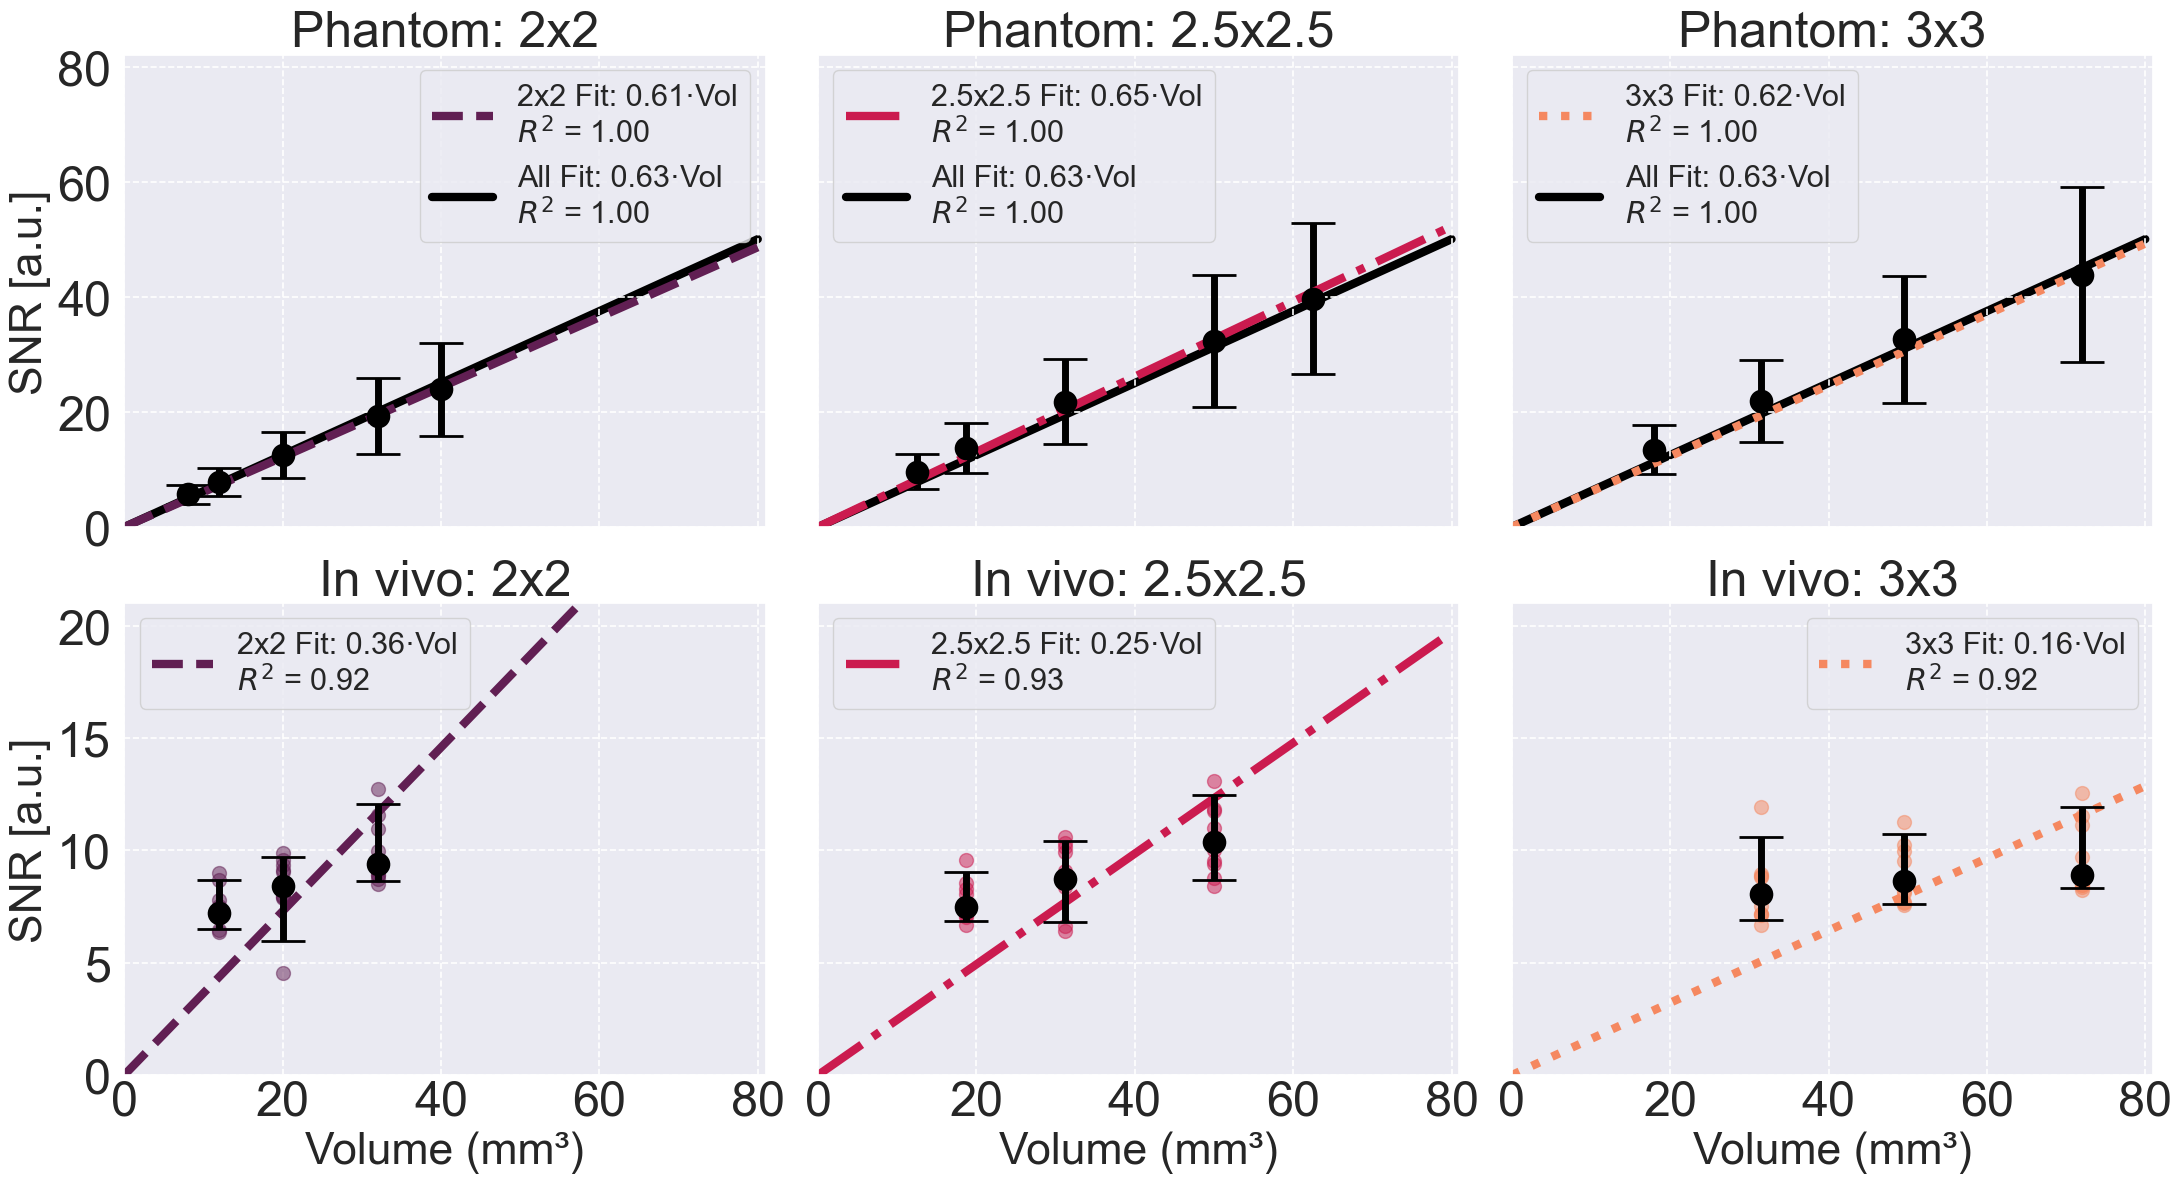

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn.linear_model import LinearRegression

# ----------------- Fitting Functions -----------------
fit_through_origin = True

def fit_with_intercept(x, y):
    x = x.reshape(-1, 1)
    model = LinearRegression().fit(x, y)
    y_pred = model.predict(x)
    r2 = model.score(x, y)
    return model.coef_[0], model.intercept_, r2, y_pred

def fit_through_origin_func(x, y):
    x = x.reshape(-1, 1)
    model = LinearRegression(fit_intercept=False).fit(x, y)
    y_pred = model.predict(x)
    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum(y**2)  # R² relative to zero
    r2_relative = 1 - ss_res / ss_tot
    return model.coef_[0], 0.0, r2_relative, y_pred

def fit_func(x, y):
    return fit_through_origin_func(x, y) if fit_through_origin else fit_with_intercept(x, y)

# ----------------- Global Style -----------------
sns.set(style='darkgrid', palette='Set2')
plt.rcParams.update({
    'lines.linewidth': 6,
    'lines.markersize': 10,
    'grid.linestyle': '--',
    'grid.color': 'white',
    'grid.alpha': 1,
    'grid.linewidth': 1.2,
    'axes.labelsize': 32,
    'xtick.labelsize': 35,
    'ytick.labelsize': 35,
    'xtick.direction': 'in',
    'xtick.major.size': 8,
    'xtick.major.width': 2,
    'legend.fontsize': 22,
    'axes.titlesize': 36,
})

# ----------------- Custom tick settings -----------------
XTICKS = [0, 20, 40, 60, 80]
YTICKS_TOP = [0, 20, 40, 60, 80]
YTICKS_BOTTOM = [0, 5, 10, 15, 20]

# ----------------- Layout -----------------
fig = plt.figure(figsize=(22, 12), dpi=100)
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1])

# Top row: Phantoms
ax_phantoms = [fig.add_subplot(gs[0, i]) for i in range(3)]
for i in range(1, 3):
    ax_phantoms[i].sharey(ax_phantoms[0])
    ax_phantoms[i].sharex(ax_phantoms[0])

# Bottom row: Volunteers
ax_vols = [fig.add_subplot(gs[1, i], sharex=ax_phantoms[i]) for i in range(3)]
for i in range(1, 3):
    ax_vols[i].sharey(ax_vols[0])

# ----------------- Colors & Linestyles -----------------
sns_colors = sns.color_palette("rocket", 3)
colors = {'2x2': sns_colors[0], '2.5x2.5': sns_colors[1], '3x3': sns_colors[2]}
linestyles = {'2x2': '--', '2.5x2.5': '-.', '3x3': ':'}

# ----------------- Phantom plots -----------------
for ax, group in zip(ax_phantoms, ['2x2', '2.5x2.5', '3x3']):
    group_data = phantom_df[phantom_df['Group'] == group]
    
    # Errorbar with outlined markers
    ax.errorbar(
        group_data['Volume'], group_data['SNR'], yerr=group_data['SNR_std'],
        fmt='o', color='black', markerfacecolor='black',
        markeredgecolor='black', markeredgewidth=2,
        elinewidth=5, capsize=16, markersize=15
    )
    
    # Fit through origin
    k, _, r2, _ = fit_func(group_data['Volume'].values, group_data['SNR'].values)
    x_fit = np.linspace(0, 80, 100)
    ax.plot(x_fit, k*x_fit, linestyle=linestyles[group], color=colors[group],
            label=f'{group} Fit: {k:.2f}·Vol\n$R^2$ = {r2:.2f}', linewidth=6)
    
    # Overall fit
    k_all, _, r2_all, _ = fit_func(phantom_df['Volume'].values, phantom_df['SNR'].values)
    ax.plot(x_fit, k_all*x_fit, color='black', linestyle='-', linewidth=6, zorder=-1,
            label=f'All Fit: {k_all:.2f}·Vol\n$R^2$ = {r2_all:.2f}')
    
    ax.set_title(f'Phantom: {group}')
    ax.set_xlabel('Volume (mm³)')
    ax.set_xticks(XTICKS)
    ax.set_yticks(YTICKS_TOP)
    ax.set_xlim(0, 81)
    ax.set_ylim(0, 82)
    ax.grid(True)
    ax.legend()

# ----------------- Volunteer plots -----------------
for ax, group in zip(ax_vols, ['2x2', '2.5x2.5', '3x3']):
    df_group = volunteer_df[volunteer_df['Inplane'] == group]
    
    # Bootstrap summary
    summary = []
    for vol in sorted(df_group['Volume'].unique()):
        snr_vals = df_group[df_group['Volume'] == vol]['SNR'].values
        median, ci_low, ci_high = Bootstrap_95_CI(snr_vals)
        summary.append({'Volume': vol, 'Median_SNR': median,
                        'CI_low': ci_low, 'CI_high': ci_high})
    summary_df = pd.DataFrame(summary)
    
    # Scatter
    ax.scatter(df_group['Volume'], df_group['SNR'],
               color=colors[group], s=100, alpha=0.5)
    
    # Errorbar
    ax.errorbar(
        summary_df['Volume'], summary_df['Median_SNR'],
        yerr=[summary_df['Median_SNR'] - summary_df['CI_low'],
              summary_df['CI_high'] - summary_df['Median_SNR']],
        fmt='o', color='black', markerfacecolor='black',
        markeredgecolor='black', markeredgewidth=2,
        elinewidth=5, capsize=16, markersize=15, zorder=3
    )
    
    # Fit through origin
    k, _, r2, _ = fit_func(df_group['Volume'].values, df_group['SNR'].values)
    x_fit = np.linspace(0, 80, 100)
    ax.plot(x_fit, k*x_fit, color=colors[group], linestyle=linestyles[group],
            label=f'{group} Fit: {k:.2f}·Vol\n$R^2$ = {r2:.2f}', linewidth=6)
    
    ax.set_title(f'In vivo: {group}')
    ax.set_xlabel('Volume (mm³)')
    ax.set_xticks(XTICKS)
    ax.set_yticks(YTICKS_BOTTOM)
    ax.set_xlim(0, 81)
    ax.set_ylim(0, 21)
    ax.grid(True)
    ax.legend()

# ----------------- Axis labels -----------------
ax_phantoms[0].set_ylabel('SNR [a.u.]')
ax_vols[0].set_ylabel('SNR [a.u.]')

# Ticks & labels
for ax in ax_phantoms[1:] + ax_vols[1:]:
    ax.tick_params(labelleft=False)
for ax in ax_phantoms:
    ax.tick_params(labelbottom=False)
for ax in ax_phantoms:
    ax.set_xlabel("")

# ----------------- Final layout -----------------
plt.tight_layout(h_pad=0.25, rect=[0, 0, 1, 1])
plt.show()
fig.savefig('SNR_vs_Volume_updated.svg', dpi=300, bbox_inches='tight')

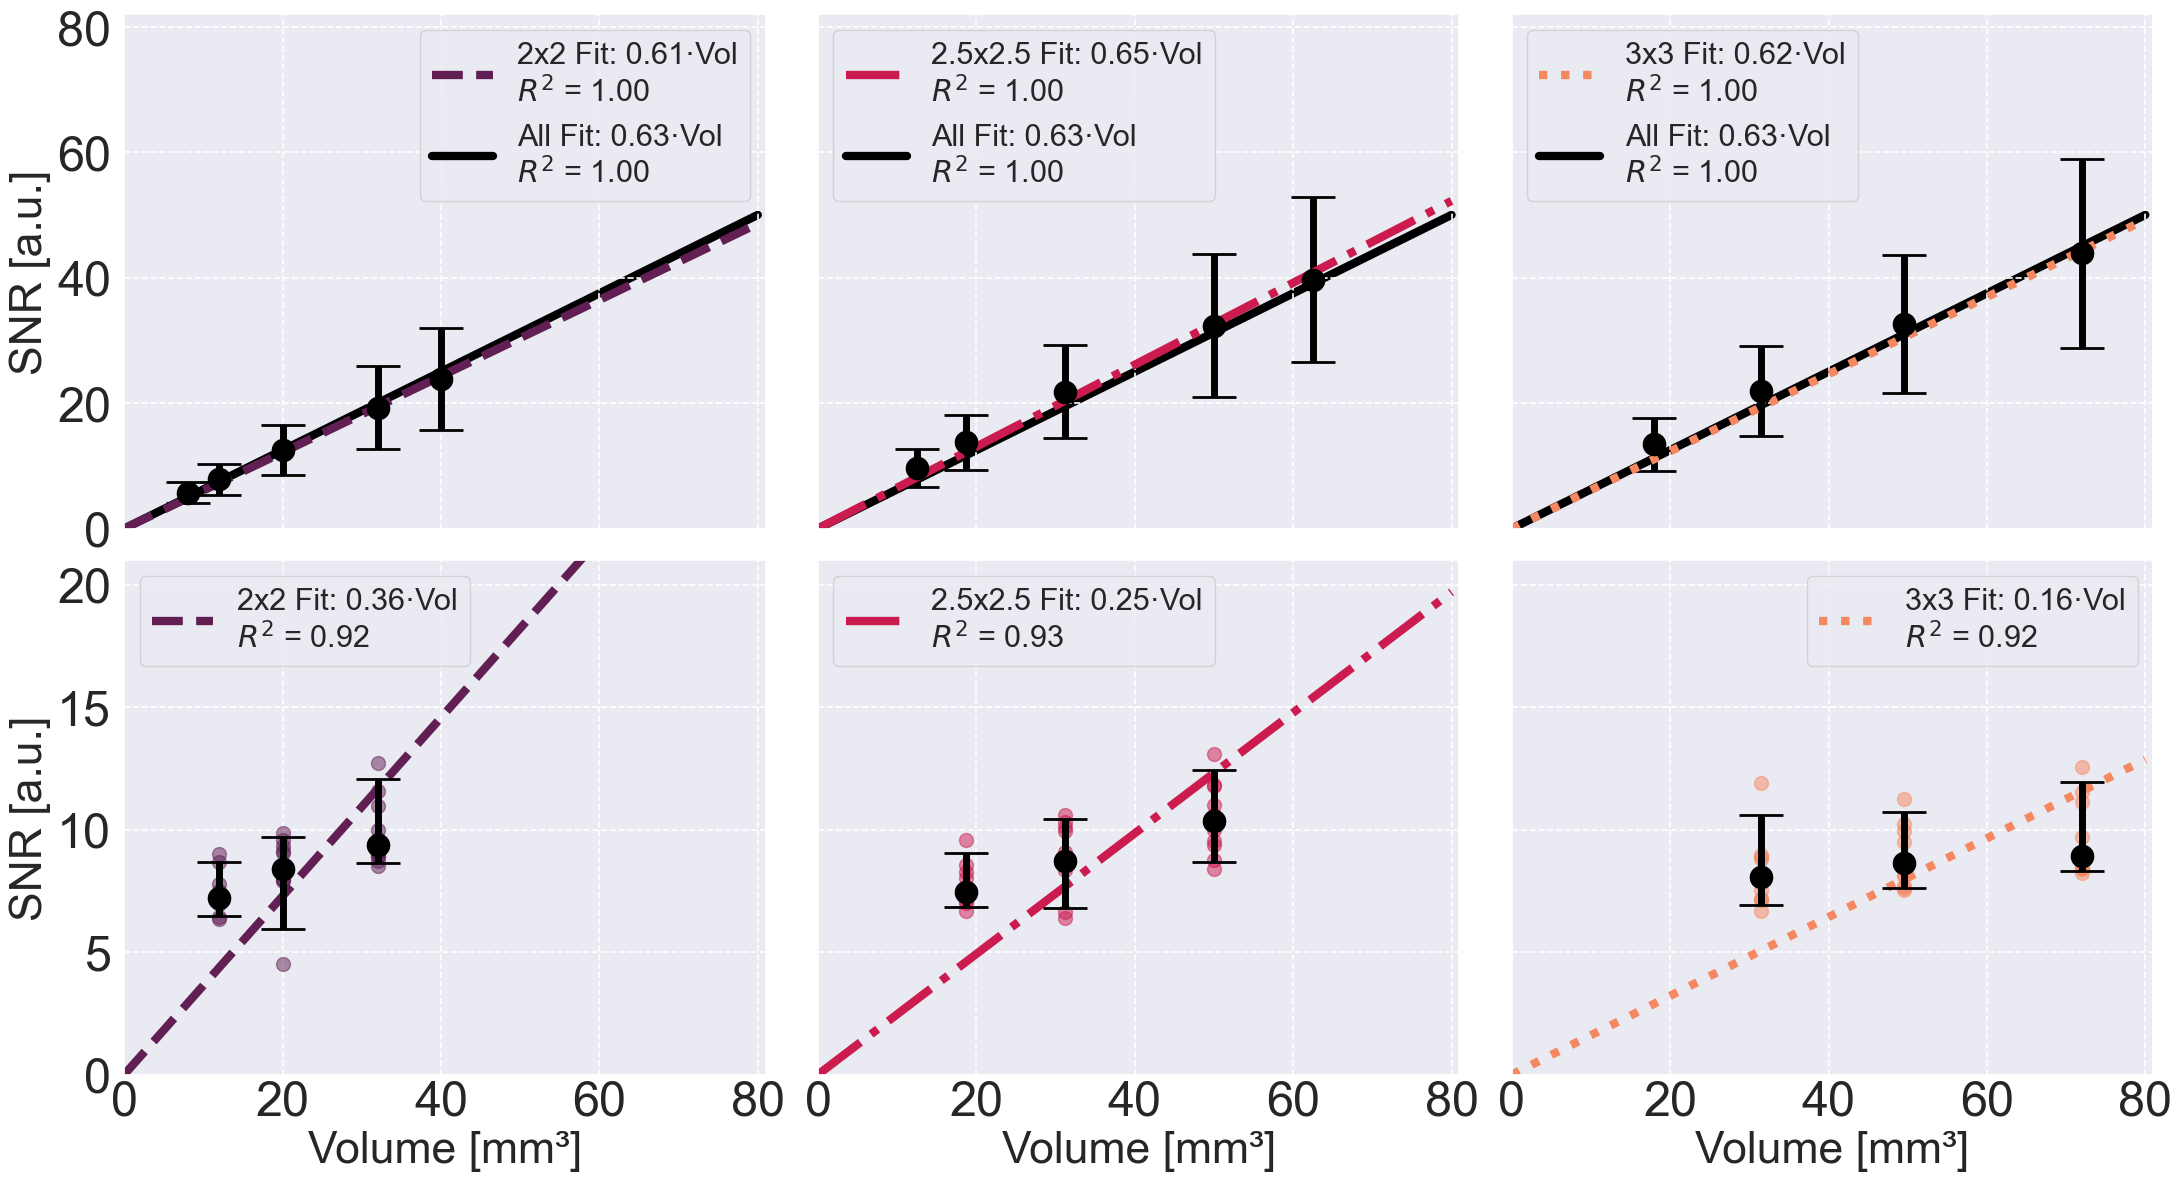

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn.linear_model import LinearRegression

# ----------------- Fitting Functions -----------------
fit_through_origin = True

def fit_with_intercept(x, y):
    x = x.reshape(-1, 1)
    model = LinearRegression().fit(x, y)
    y_pred = model.predict(x)
    r2 = model.score(x, y)
    return model.coef_[0], model.intercept_, r2, y_pred

def fit_through_origin_func(x, y):
    x = x.reshape(-1, 1)
    model = LinearRegression(fit_intercept=False).fit(x, y)
    y_pred = model.predict(x)
    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum(y**2)  # R² relative to zero
    r2_relative = 1 - ss_res / ss_tot
    return model.coef_[0], 0.0, r2_relative, y_pred

def fit_func(x, y):
    return fit_through_origin_func(x, y) if fit_through_origin else fit_with_intercept(x, y)

# ----------------- Global Style -----------------
sns.set(style='darkgrid', palette='Set2')
plt.rcParams.update({
    'lines.linewidth': 6,
    'lines.markersize': 10,
    'grid.linestyle': '--',
    'grid.color': 'white',
    'grid.alpha': 1,
    'grid.linewidth': 1.2,
    'axes.labelsize': 32,
    'xtick.labelsize': 35,
    'ytick.labelsize': 35,
    'xtick.direction': 'in',
    'xtick.major.size': 8,
    'xtick.major.width': 2,
    'legend.fontsize': 22,
    'axes.titlesize': 36,
})

# ----------------- Custom tick settings -----------------
XTICKS = [0, 20, 40, 60, 80]
YTICKS_TOP = [0, 20, 40, 60, 80]
YTICKS_BOTTOM = [0, 5, 10, 15, 20]

# ----------------- Layout -----------------
fig = plt.figure(figsize=(22, 12), dpi=100)
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1])

# Top row: Phantoms
ax_phantoms = [fig.add_subplot(gs[0, i]) for i in range(3)]
for i in range(1, 3):
    ax_phantoms[i].sharey(ax_phantoms[0])
    ax_phantoms[i].sharex(ax_phantoms[0])

# Bottom row: Volunteers
ax_vols = [fig.add_subplot(gs[1, i], sharex=ax_phantoms[i]) for i in range(3)]
for i in range(1, 3):
    ax_vols[i].sharey(ax_vols[0])

# ----------------- Colors & Linestyles -----------------
sns_colors = sns.color_palette("rocket", 3)
colors = {'2x2': sns_colors[0], '2.5x2.5': sns_colors[1], '3x3': sns_colors[2]}
linestyles = {'2x2': '--', '2.5x2.5': '-.', '3x3': ':'}

# ----------------- Phantom plots -----------------
for ax, group in zip(ax_phantoms, ['2x2', '2.5x2.5', '3x3']):
    group_data = phantom_df[phantom_df['Group'] == group]
    
    # Errorbar with outlined markers
    ax.errorbar(
        group_data['Volume'], group_data['SNR'], yerr=group_data['SNR_std'],
        fmt='o', color='black', markerfacecolor='black',
        markeredgecolor='black', markeredgewidth=2,
        elinewidth=5, capsize=16, markersize=15
    )
    
    # Fit through origin
    k, _, r2, _ = fit_func(group_data['Volume'].values, group_data['SNR'].values)
    x_fit = np.linspace(0, 80, 100)
    ax.plot(x_fit, k*x_fit, linestyle=linestyles[group], color=colors[group],
            label=f'{group} Fit: {k:.2f}·Vol\n$R^2$ = {r2:.2f}', linewidth=6)
    
    # Overall fit
    k_all, _, r2_all, _ = fit_func(phantom_df['Volume'].values, phantom_df['SNR'].values)
    ax.plot(x_fit, k_all*x_fit, color='black', linestyle='-', linewidth=6, zorder=-1,
            label=f'All Fit: {k_all:.2f}·Vol\n$R^2$ = {r2_all:.2f}')
    
    #ax.set_title(f'Phantom: {group}')
    ax.set_xlabel('Volume [mm³]')
    ax.set_xticks(XTICKS)
    ax.set_yticks(YTICKS_TOP)
    ax.set_xlim(0, 81)
    ax.set_ylim(0, 82)
    ax.grid(True)
    ax.legend()

# ----------------- Volunteer plots -----------------
for ax, group in zip(ax_vols, ['2x2', '2.5x2.5', '3x3']):
    df_group = volunteer_df[volunteer_df['Inplane'] == group]
    
    # Bootstrap summary
    summary = []
    for vol in sorted(df_group['Volume'].unique()):
        snr_vals = df_group[df_group['Volume'] == vol]['SNR'].values
        median, ci_low, ci_high = Bootstrap_95_CI(snr_vals)
        summary.append({'Volume': vol, 'Median_SNR': median,
                        'CI_low': ci_low, 'CI_high': ci_high})
    summary_df = pd.DataFrame(summary)
    
    # Scatter
    ax.scatter(df_group['Volume'], df_group['SNR'],
               color=colors[group], s=100, alpha=0.5)
    
    # Errorbar
    ax.errorbar(
        summary_df['Volume'], summary_df['Median_SNR'],
        yerr=[summary_df['Median_SNR'] - summary_df['CI_low'],
              summary_df['CI_high'] - summary_df['Median_SNR']],
        fmt='o', color='black', markerfacecolor='black',
        markeredgecolor='black', markeredgewidth=2,
        elinewidth=5, capsize=16, markersize=15, zorder=3
    )
    
    # Fit through origin
    k, _, r2, _ = fit_func(df_group['Volume'].values, df_group['SNR'].values)
    x_fit = np.linspace(0, 80, 100)
    ax.plot(x_fit, k*x_fit, color=colors[group], linestyle=linestyles[group],
            label=f'{group} Fit: {k:.2f}·Vol\n$R^2$ = {r2:.2f}', linewidth=6)
    
    #ax.set_title(f'In vivo: {group}')
    ax.set_xlabel('Volume [mm³]')
    ax.set_xticks(XTICKS)
    ax.set_yticks(YTICKS_BOTTOM)
    ax.set_xlim(0, 81)
    ax.set_ylim(0, 21)
    ax.grid(True)
    ax.legend()

# ----------------- Axis labels -----------------
ax_phantoms[0].set_ylabel('SNR [a.u.]')
ax_vols[0].set_ylabel('SNR [a.u.]')

# Ticks & labels
for ax in ax_phantoms[1:] + ax_vols[1:]:
    ax.tick_params(labelleft=False)
for ax in ax_phantoms:
    ax.tick_params(labelbottom=False)
for ax in ax_phantoms:
    ax.set_xlabel("")

# ----------------- Final layout -----------------
plt.tight_layout(h_pad=0.25, rect=[0, 0, 1, 1])
plt.show()
fig.savefig('SNR_vs_Volume_nolegend.svg', dpi=300, bbox_inches='tight')